<a href="https://colab.research.google.com/github/injoon-pij/dlnlp-learning/blob/main/dlnlp_vector_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Cosine Similarity

두 벡터 간의 코사인 각도를 이용하여 구할 수 있는 두 벡터의 유사도

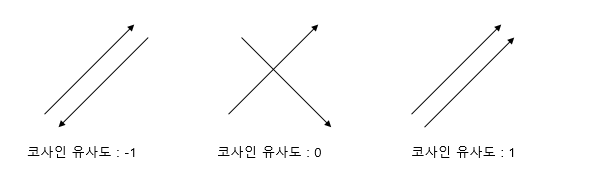

* 코사인 유사도는 -1 이상 1 이하의 값을 가지며, 값이 1에 가까울 수록 유사도가 높다고 판단됨. 즉 두 벡터의 방향이 얼마나 유사한가에 대한 정도.

* $\text{cosine similarity} = cos(\text{Θ})=\frac{A\text{⋅}B}{||A||\ ||B||} = \frac{\sum_{i=1}^{n}{A_{i}\text{×}B_{i}}}{\sqrt{\sum_{i=1}^{n}(A_{i})^2}\text{×}\sqrt{\sum_{i=1}^{n}(B_{i})^2}}$

 * 문서단어행렬(DTM)이나 TF-IDF 행렬을 통해서 문서의 코사인 유사도를 구하는 경우, 각 문서의 행렬벡터가 각각의 특징벡터 A와 B가 됨

Numpy를 이용해서 유사도 계산

In [ ]:
from numpy import dot
from numpy.linalg import norm
import numpy as np

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [ ]:
doc1 = np.array([0,1,1,1])
doc2 = np.array([1,0,1,1])
doc3 = np.array([2,0,2,2])

In [ ]:
print(cos_sim(doc1, doc2)) # 문서1과 문서2의 코사인 유사도
print(cos_sim(doc1, doc3)) # 문서1과 문서3의 코사인 유사도
print(cos_sim(doc2, doc3)) # 문서2과 문서3의 코사인 유사도

0.6666666666666667
0.6666666666666667
1.0000000000000002


* 코사인 유사도는 문서의 길이가 다른 상황에서 비교적 공정한 비교를 할 수 있도록 도와줌

 * 문서1-문서2의 코사인 유사도와 문서1-문서3의 코사인 유사도가 동일함. 즉 문서의 패턴이 동일하다면 문서의 길이가 더 길다는 이유로 유사도가 높아지는 일이 일어나지 않음.

 * 코사인 유사도는 벡터의 크기가 아닌 방향을 기준으로 한 비교 방법이기 때문

## 1.1 Recommendation System by Similarity

캐글의 영화 데이터셋을 TF-IDF와 코사인 유사도을 사용하여 영화의 줄거리에 기반한 영화 추천 시스템 실습

[데이터 다운로드 링크](https://www.kaggle.com/rounakbanik/the-movies-dataset)

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [8]:
data = pd.read_csv('./movies_metadata.csv', low_memory = False)
data.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


* 판다스는 데이터의 dtype을 알아내는데에 많은 메모리가 쓰이므로 항상 dtype을 지정하여 불러오는 것을 권장함.
* low_memory = False 지정은 dtype을 지정하지 않아 오류가 생겼을 때에 오류를 해결해줌

In [9]:
# 2000개의 샘플만 데이터 사용
data = data.head(20000)

# 리뷰 데이터에 null 값이 존재하는지 확인
data['overview'].isnull().sum()

135

* 135개의 샘플에 null 값 존재
* tf-idf 연산시 데이터에 null 값이 들어가있으면 에러가 발생함

In [10]:
# pandas를 이용하여 null 값을 처리하는 도구인 fillna()를 사용
data['overview'] = data['overview'].fillna('') # null값을 빈 값으로 대체

# 리뷰 데이터에 null 값이 존재하는지 재확인
data['overview'].isnull().sum()

0

In [11]:
tfidf = TfidfVectorizer(stop_words = 'english')

# overview에 대해서 tf-idf 수행
tfidf_matrix = tfidf.fit_transform(data['overview'])
print(tfidf_matrix.shape)

(20000, 47487)


* 20,000개의 영화 리뷰 데이터를 표현하기위해 총 47,487개의 단어가 사용되었음

In [15]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix) # 두 행렬의 내적
print(cosine_sim.shape)

(20000, 20000)


In [16]:
# 영화의 타이틀과 인덱스를 가진 테이블
indices = pd.Series(data.index, index=data['title']).drop_duplicates()
print(indices.head())

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64


* ```drop_duplicates()``` : 중복값 제거

In [17]:
# 코사인 유사도를 이용하여 가장 overview가 유사한 영화 10개를 찾아내는 함수

def get_recommendations(title, cosine_sim = cosine_sim):
  idx = indices[title]
  
  # 모든 영화에 대해서 해당 영화와의 유사도를 구합니다.
  sim_scores = list(enumerate(cosine_sim[idx]))

  # 유사도에 따라 정렬
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # 내림차순
  sim_scores = sim_scores[1:11]

  movie_indices = [i[0] for i in sim_scores]
    
  return data['title'].iloc[movie_indices]

* ```iloc``` : 데이터프레임의 행이나 컬럼에 인덱스 값으로 접근 (integer indexing)
 * cf.) ```loc``` : 데이터프레임의 행이나 컬럼에 label이나 boolean array로 접근

In [18]:
get_recommendations('The Dark Knight Rises')

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object

# 2) Other Vector Similarity

## 2.1 Euclidean distance

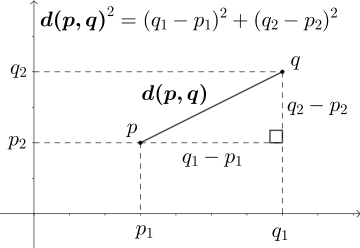

* 유클리드 거리를 통해 문서 유사도 계산

In [1]:
import numpy as np

def dist(x, y):
  return np.sqrt(np.sum((x-y) ** 2))

In [2]:
doc1 = np.array((2,3,0,1))
doc2 = np.array((1,2,3,1))
doc3 = np.array((2,1,2,2))
docQ = np.array((1,1,0,1))

print(dist(doc1,docQ))
print(dist(doc2,docQ))
print(dist(doc3,docQ))

2.23606797749979
3.1622776601683795
2.449489742783178


* 문서Q는 문서1과 가장 유사하다

## 2.2 Jaccard similarity

A와 B 두개의 집합이 있다고 할 때, 합집합에 대한 교집합의 비율을 구한다면 두 집합 A와 B의 유사도를 구할 수 있다는 것이 자카드 유사도(jaccard similarity)의 아이디어

* $J(A,B)=\frac{|A\text{∩}B|}{|A\text{∪}B|}=\frac{|A\text{∩}B|}{|A|+|B|-|A\text{∩}B|}$

* 위의 유사도를 문서 유사도에 적용하면 $J(\text{doc}_{1},\text{doc}_{2})=\frac{\text{doc}_{1}\text{∩}\text{doc}_{2}}{\text{doc}_{1}\text{∪}\text{doc}_{2}}$

In [3]:
doc1 = "apple banana everyone like likey watch card holder"
doc2 = "apple banana coupon passport love you"

tokenized_doc1 = doc1.split()
tokenized_doc2 = doc2.split()

print(tokenized_doc1)
print(tokenized_doc2)

['apple', 'banana', 'everyone', 'like', 'likey', 'watch', 'card', 'holder']
['apple', 'banana', 'coupon', 'passport', 'love', 'you']


In [6]:
# 합집합
union = set(tokenized_doc1).union(set(tokenized_doc2))
print(union)

# 교집합
intersection = set(tokenized_doc1).intersection(set(tokenized_doc2))
print(intersection)

# 자카드 유사도
print(len(intersection)/len(union))

{'banana', 'passport', 'apple', 'love', 'holder', 'like', 'you', 'coupon', 'everyone', 'likey', 'watch', 'card'}
{'apple', 'banana'}
0.16666666666666666


* 위의 계산값은 자카드 유사도이자, 두 문서의 총 단어 집합에서 두 문서에서 공통적으로 등장한 단어의 비율이기도 함